In [1]:
from lc_classifier.classifiers.ztf_mlp import ZTFClassifier
import pandas as pd
from sklearn.model_selection import train_test_split

2023-11-20 21:36:27.650141: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 21:36:27.682811: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-20 21:36:27.683727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 21:36:28.236245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
features = pd.read_parquet('data/consolidated_features.parquet')
labels = pd.read_pickle('data/objects.pkl')
labels.rename(
    columns={
        'alerceclass': 'astro_class',
        'oid': 'aid'
    }, inplace=True)
labels = labels[['aid', 'astro_class']]
labels.set_index('aid', inplace=True)
labels = labels.loc[features.index]

# make partitions
seed = 0
aid_train_val, aid_test = train_test_split(
    labels.index.values,
    stratify=labels['astro_class'].values,
    test_size=0.2,
    random_state=seed)

labels_train_val = labels.loc[aid_train_val]
aid_train, aid_val = train_test_split(
    aid_train_val,
    stratify=labels_train_val['astro_class'].values,
    train_size=0.75,
    random_state=seed)

labels_training = labels.loc[aid_train].copy()
labels_training['partition'] = 'training'

labels_validation = labels.loc[aid_val].copy()
labels_validation['partition'] = 'validation'

labels_test = labels.loc[aid_test].copy()
labels_test['partition'] = 'test'

labels = pd.concat([labels_training, labels_validation, labels_test])
labels.index.name = 'aid'
labels.reset_index(inplace=True)

list_of_classes = labels['astro_class'].unique()

In [3]:
list_of_classes, len(labels_training)

(array(['SNIa', 'QSO', 'RSCVn', 'AGN', 'EBEW', 'EA', 'Ceph',
        'Periodic-Other', 'Blazar', 'RRLab', 'CVNova', 'nonSNIa', 'YSO',
        'DSCT', 'RRLc', 'LPV'], dtype=object),
 10612)

In [4]:
labels_test.groupby('astro_class').count()

,partition
astro_class,
AGN,240
Blazar,240
CVNova,212
Ceph,157
DSCT,203
EA,240
EBEW,240
LPV,242
Periodic-Other,152


In [5]:
ztf_classifier = ZTFClassifier(list_of_classes)
config = {
    'learning_rate': 1e-4,
    'batch_size': 256
}
ztf_classifier.fit_from_features(features, labels, config)
ztf_classifier.save_classifier('ztf_classifier_model')

2023-11-20 21:36:30.919393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-20 21:36:30.919923: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


iteration 250 training loss 2.864000e+00 lr 1.660000e-05
iteration 500 training loss 1.848410e+00 lr 3.326666e-05
iteration 750 training loss 1.604821e+00 lr 4.993333e-05
iteration 1000 training loss 1.441654e+00 lr 6.660000e-05
iteration 1250 training loss 1.413018e+00 lr 8.326667e-05
iteration 1500 training loss 1.453751e+00 lr 9.993333e-05
iteration 1750 training loss 1.306812e+00 lr 9.997674e-05
iteration 2000 training loss 1.261953e+00 lr 9.990664e-05
iteration 2250 training loss 1.295067e+00 lr 9.978975e-05
iteration 2500 training loss 1.286267e+00 lr 9.962620e-05
                precision    recall  f1-score   support

           AGN       0.61      0.60      0.61       239
        Blazar       0.66      0.50      0.57       240
        CVNova       0.86      0.71      0.78       212
          Ceph       0.75      0.71      0.73       157
          DSCT       0.87      0.91      0.89       203
            EA       0.83      0.93      0.87       239
          EBEW       0.80     

iteration 12750 training loss 9.240806e-01 lr 5.993653e-05
iteration 13000 training loss 8.887866e-01 lr 5.845925e-05
iteration 13250 training loss 9.904106e-01 lr 5.697609e-05
iteration 13500 training loss 9.161942e-01 lr 5.548851e-05
iteration 13750 training loss 9.336185e-01 lr 5.399797e-05
iteration 14000 training loss 1.039340e+00 lr 5.250597e-05
iteration 14250 training loss 8.480156e-01 lr 5.101395e-05
iteration 14500 training loss 9.173303e-01 lr 4.952341e-05
iteration 14750 training loss 9.363935e-01 lr 4.803580e-05
iteration 15000 training loss 8.762521e-01 lr 4.655259e-05
                precision    recall  f1-score   support

           AGN       0.69      0.56      0.62       239
        Blazar       0.67      0.54      0.60       240
        CVNova       0.92      0.77      0.84       212
          Ceph       0.83      0.72      0.77       157
          DSCT       0.91      0.93      0.92       203
            EA       0.90      0.93      0.91       239
          EBEW   

iteration 25250 training loss 8.317486e-01 lr 5.585737e-06
iteration 25500 training loss 8.575212e-01 lr 5.375301e-06
iteration 25750 training loss 7.921633e-01 lr 5.211368e-06
iteration 26000 training loss 8.638546e-01 lr 5.094104e-06
iteration 26250 training loss 8.449661e-01 lr 5.023626e-06
iteration 26500 training loss 8.665248e-01 lr 5.000000e-06
iteration 26750 training loss 7.931226e-01 lr 5.000000e-06
iteration 27000 training loss 8.455144e-01 lr 5.000000e-06
iteration 27250 training loss 8.280393e-01 lr 5.000000e-06
iteration 27500 training loss 8.285822e-01 lr 5.000000e-06
                precision    recall  f1-score   support

           AGN       0.67      0.60      0.63       239
        Blazar       0.67      0.53      0.59       240
        CVNova       0.91      0.78      0.84       212
          Ceph       0.83      0.71      0.77       157
          DSCT       0.92      0.92      0.92       203
            EA       0.89      0.94      0.91       239
          EBEW   

iteration 37750 training loss 7.798979e-01 lr 5.000000e-06
iteration 38000 training loss 7.991521e-01 lr 5.000000e-06
iteration 38250 training loss 8.402641e-01 lr 5.000000e-06
iteration 38500 training loss 8.590671e-01 lr 5.000000e-06
iteration 38750 training loss 8.311898e-01 lr 5.000000e-06
iteration 39000 training loss 8.690932e-01 lr 5.000000e-06
iteration 39250 training loss 7.904121e-01 lr 5.000000e-06
iteration 39500 training loss 8.114073e-01 lr 5.000000e-06
iteration 39750 training loss 8.422912e-01 lr 5.000000e-06
iteration 40000 training loss 9.402727e-01 lr 5.000000e-06
                precision    recall  f1-score   support

           AGN       0.67      0.59      0.63       239
        Blazar       0.68      0.54      0.60       240
        CVNova       0.90      0.78      0.83       212
          Ceph       0.84      0.71      0.77       157
          DSCT       0.91      0.92      0.92       203
            EA       0.89      0.94      0.91       239
          EBEW   

INFO:tensorflow:Assets written to: ztf_classifier_model/tf_model/assets


Saved artifact at 'ztf_classifier_model/tf_model'. The following endpoints are available:

* Endpoint 'inference'
  Args:
    x: float32 Tensor, shape=(None, 152)
  Returns:
    float32 Tensor, shape=(None, 16)


In [6]:
ztf_classifier = ZTFClassifier(list_of_classes)
ztf_classifier.load_classifier('ztf_classifier_model')

In [7]:
astro_objects = pd.read_pickle('data/astro_objects_batch_0000.pkl')
astro_objects

[AstroObject(metadata=  name             value
 0  aid  aid_ZTF17aaaaajz
 1  oid      ZTF17aaaaajz, detections=              candid  brightness  e_brightness fid           mjd  detected  \
 oid                                                                          
 ZTF17aaaaajz       5  -71.579622      8.691542   r  58303.476507      True   
 ZTF17aaaaajz      12  -89.458201      3.355334   r  58319.472755      True   
 ZTF17aaaaajz      14  -94.960172      6.686876   r  58320.486883      True   
 ZTF17aaaaajz      16  -76.501201      5.093327   r  58321.488129      True   
 ZTF17aaaaajz      19  -59.924670      5.279258   r  58323.489605      True   
 ...              ...         ...           ...  ..           ...       ...   
 ZTF17aaaaajz     979   16.941693      0.009216   r  59409.463326      True   
 ZTF17aaaaajz     980   16.955998      0.009523   r  59409.465769      True   
 ZTF17aaaaajz     981   16.936119      0.008439   r  59409.468211      True   
 ZTF17aaaaajz     982

In [8]:
ztf_classifier.classify_batch(astro_objects)

In [32]:
astro_objects[0].predictions

,name,value,fid,sid,version
0,SNIa,0.000241,None,ztf,1.0.0
1,QSO,0.000017,None,ztf,1.0.0
2,RSCVn,0.00578,None,ztf,1.0.0
3,AGN,0.00121,None,ztf,1.0.0
4,EBEW,0.000186,None,ztf,1.0.0
5,EA,0.000847,None,ztf,1.0.0
6,Ceph,0.000279,None,ztf,1.0.0
7,Periodic-Other,0.0002,None,ztf,1.0.0
8,Blazar,0.00474,None,ztf,1.0.0
9,RRLab,0.000098,None,ztf,1.0.0


In [11]:
from lc_classifier.utils import plot_astro_object

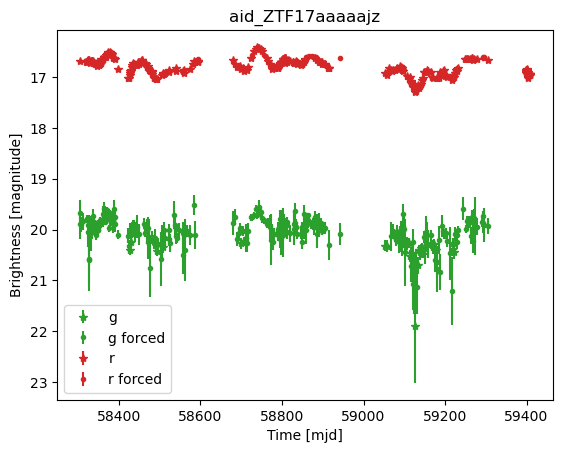

In [13]:
plot_astro_object(astro_objects[0], unit='magnitude', use_forced_phot=True)